In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox,skew
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-price-prediction-challenge/car_price_prediction.csv


In [2]:
def get_cols(data:pd.DataFrame):
    categorical_columns = data.select_dtypes([object])
    numerical_columns = data.select_dtypes([np.int64,np.float64])
    return categorical_columns,numerical_columns

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

In [4]:
data = pd.read_csv("/kaggle/input/car-price-prediction-challenge/car_price_prediction.csv")

---
## EDA

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [6]:
data.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [7]:
data['Levy']=data['Levy'].replace('-',0).astype(np.int64)
data.drop(columns=['ID'],inplace=True)

In [8]:
categorical_columns,numerical_columns = get_cols(data)

In [9]:
numerical_columns.describe()

,Price,Levy,Prod. year,Cylinders,Airbags
count,1.923700e+04,19237.000000,19237.000000,19237.000000,19237.000000
mean,1.855593e+04,632.528669,2010.912824,4.582991,6.582627
std,1.905813e+05,567.721688,5.668673,1.199933,4.320168
min,1.000000e+00,0.000000,1939.000000,1.000000,0.000000
25%,5.331000e+03,0.000000,2009.000000,4.000000,4.000000
50%,1.317200e+04,642.000000,2012.000000,4.000000,6.000000
75%,2.207500e+04,917.000000,2015.000000,4.000000,12.000000
max,2.630750e+07,11714.000000,2020.000000,16.000000,16.000000


Price


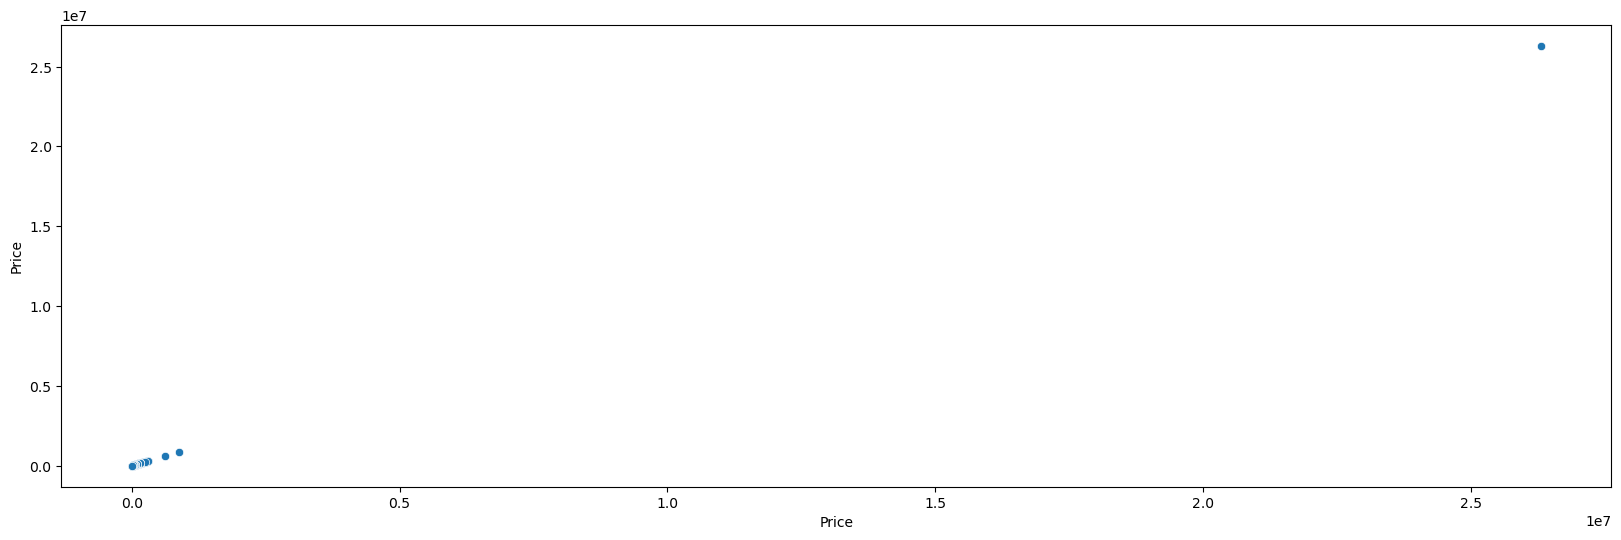

Levy


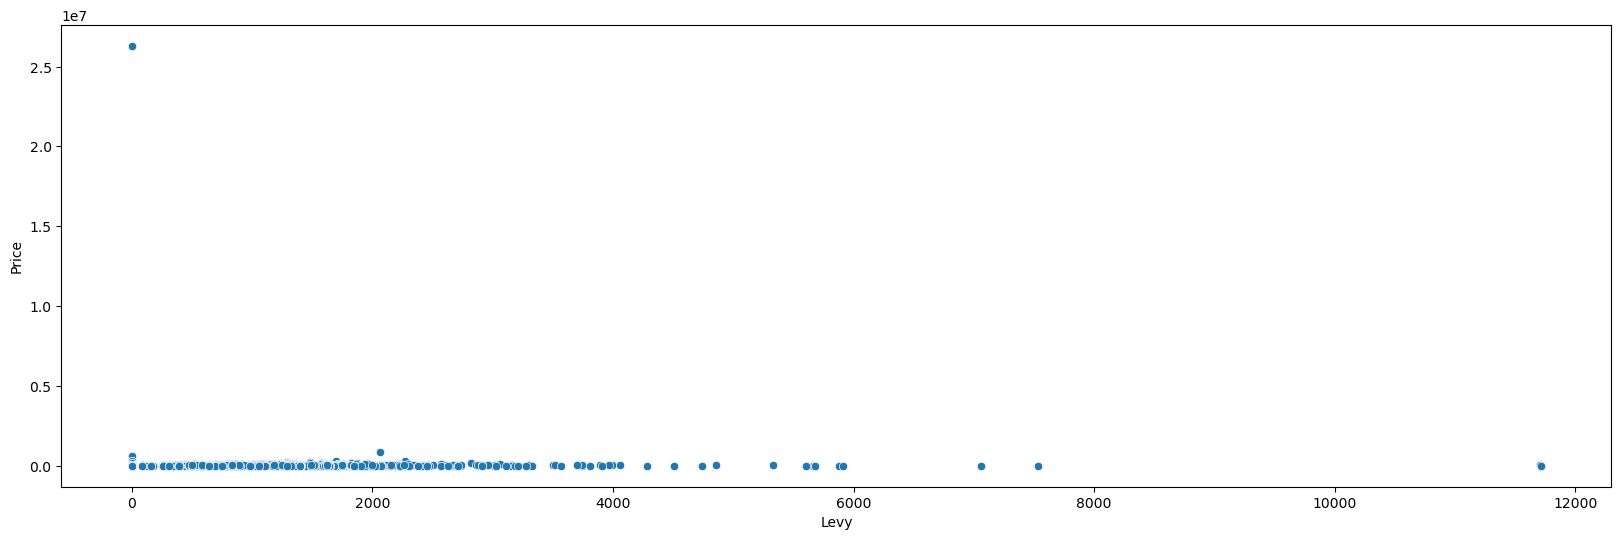

Prod. year


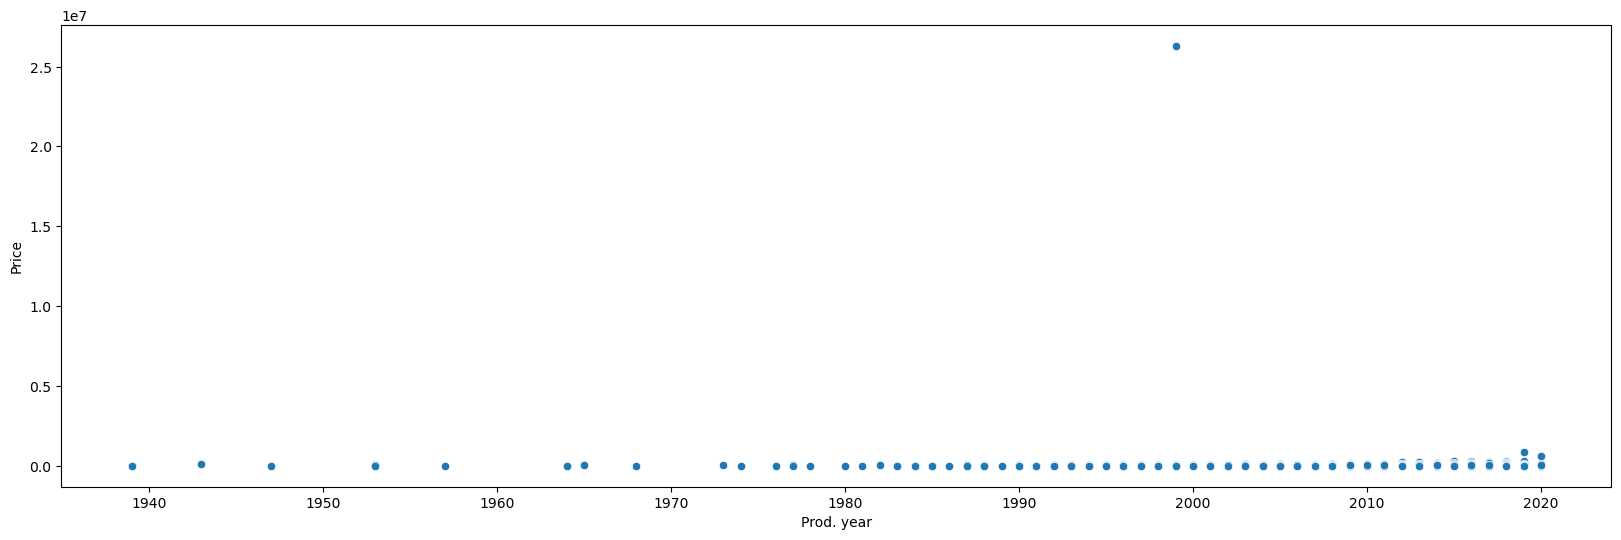

Cylinders


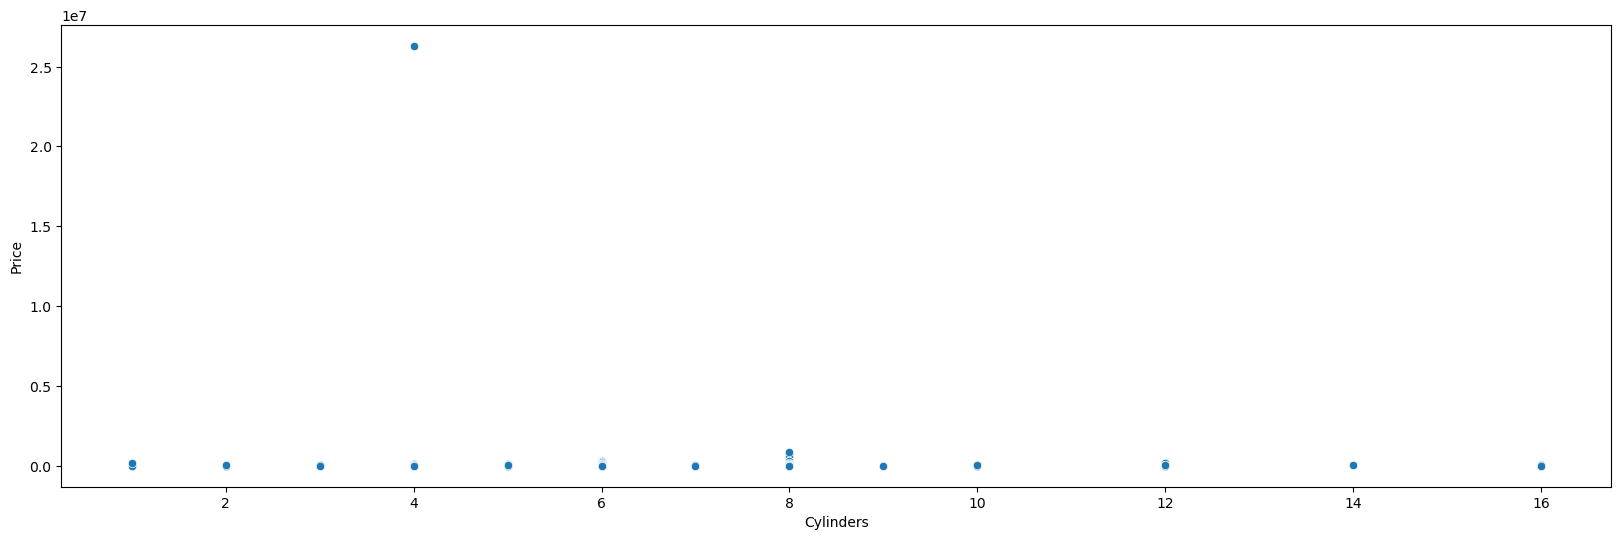

Airbags


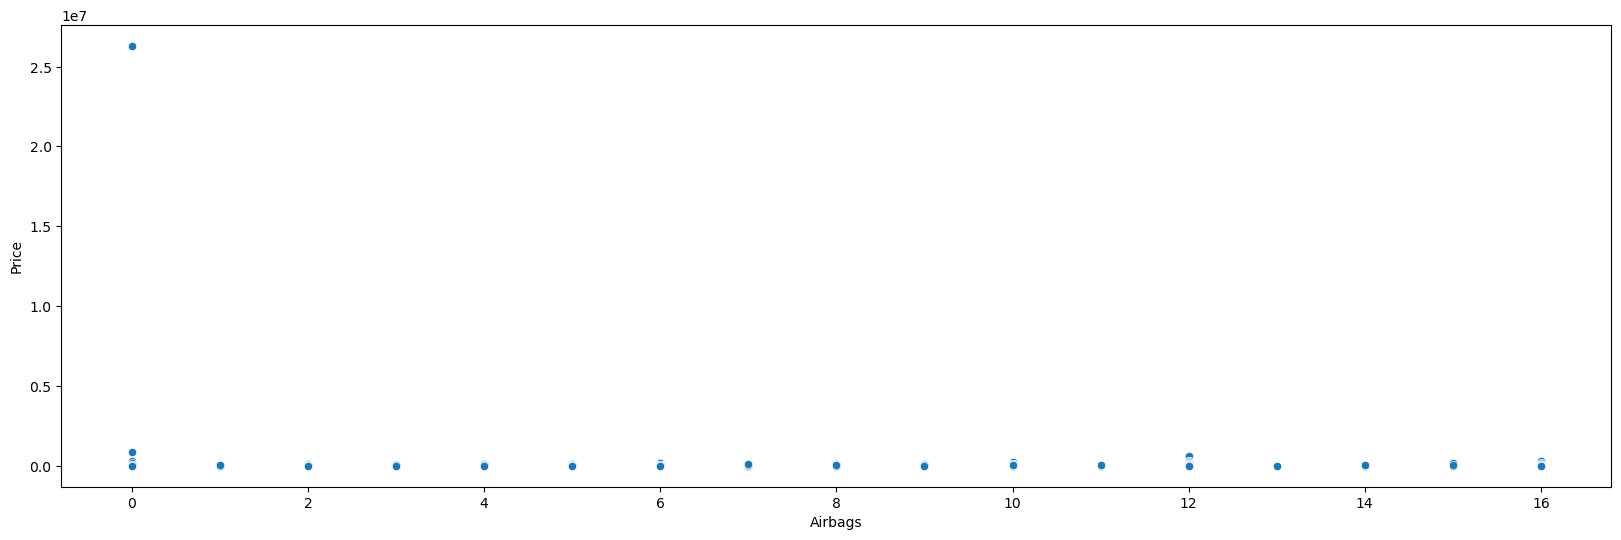

In [10]:
for i in numerical_columns:
    print(i)
    plt.figure(figsize=(20,6))
    sns.scatterplot(x=numerical_columns[i],y=data['Price'])
    plt.show()

Manufacturer


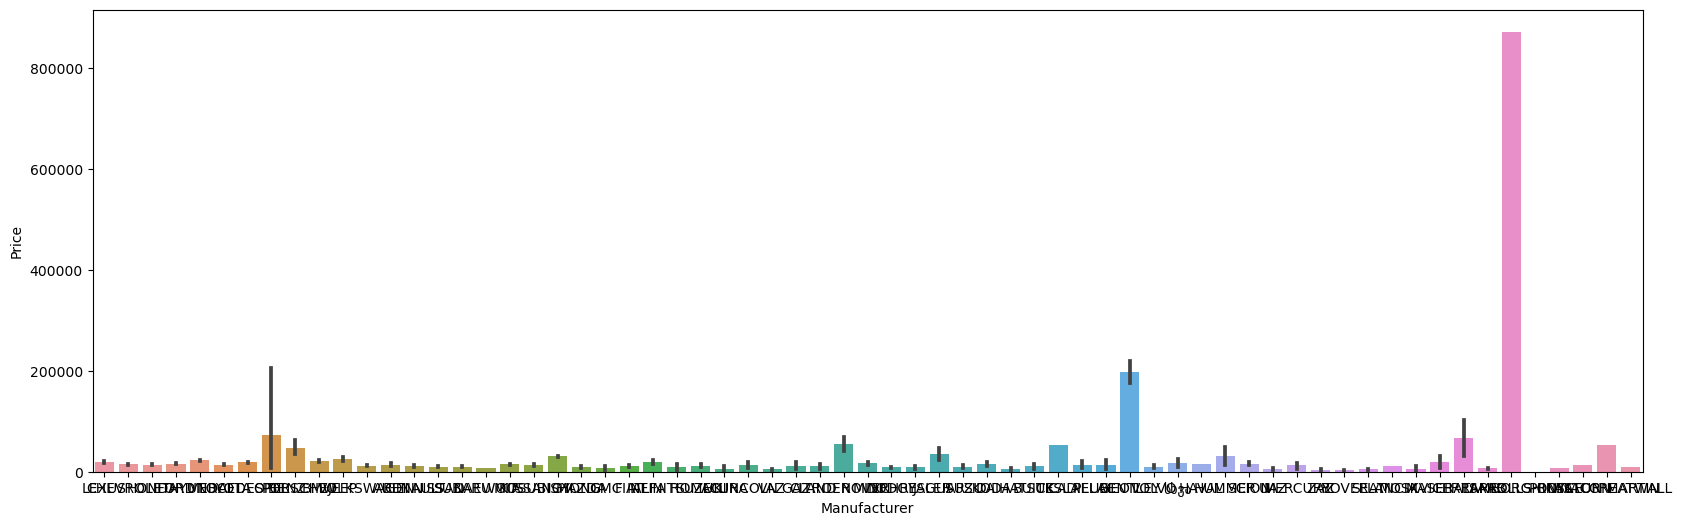

Model


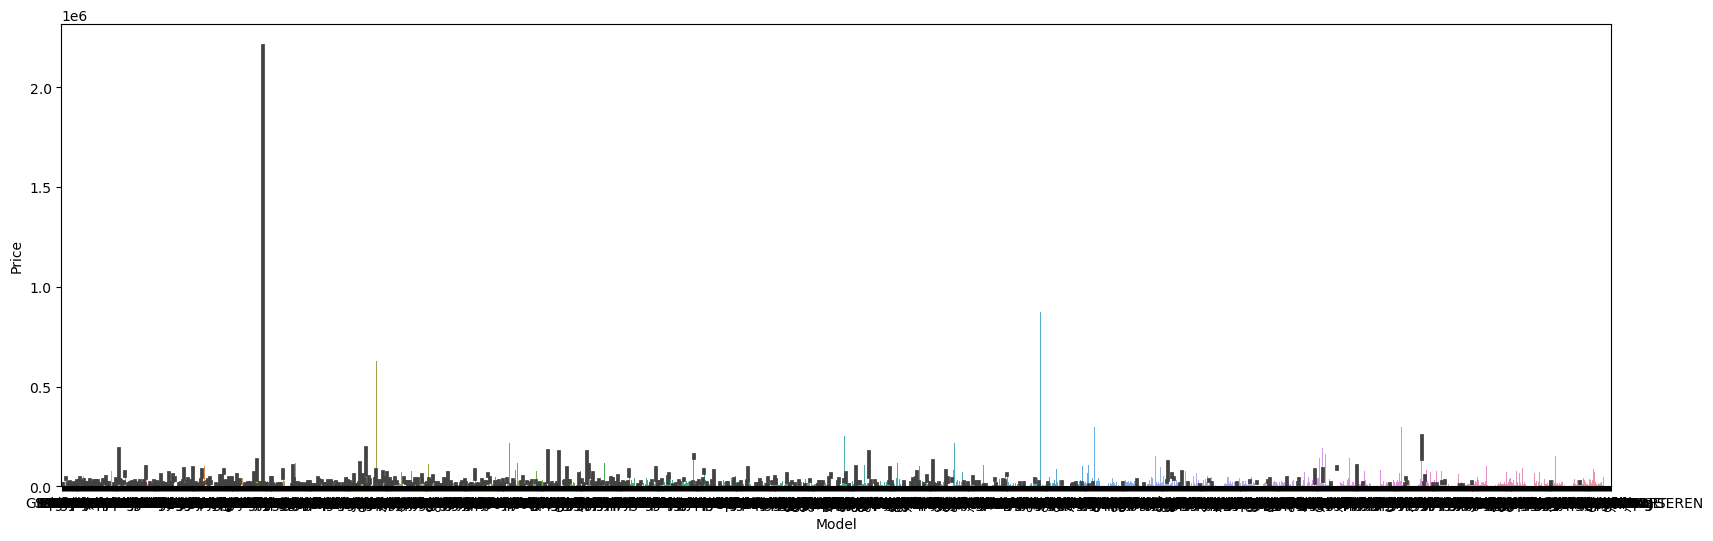

Category


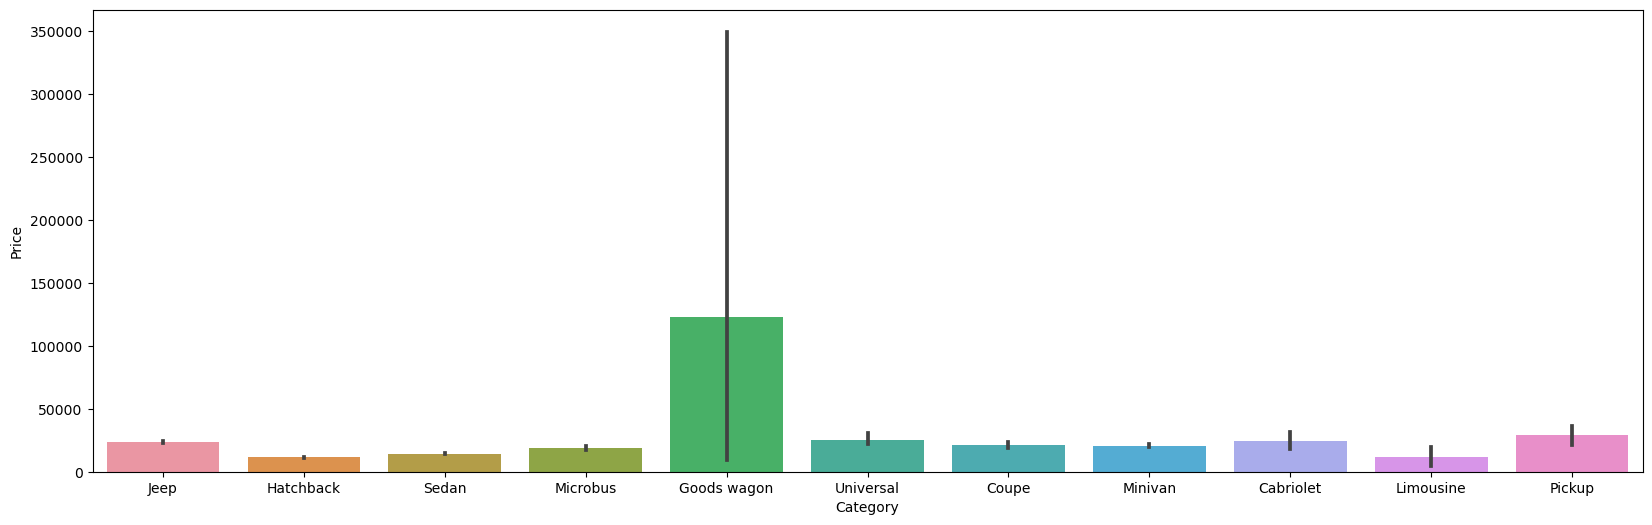

Leather interior


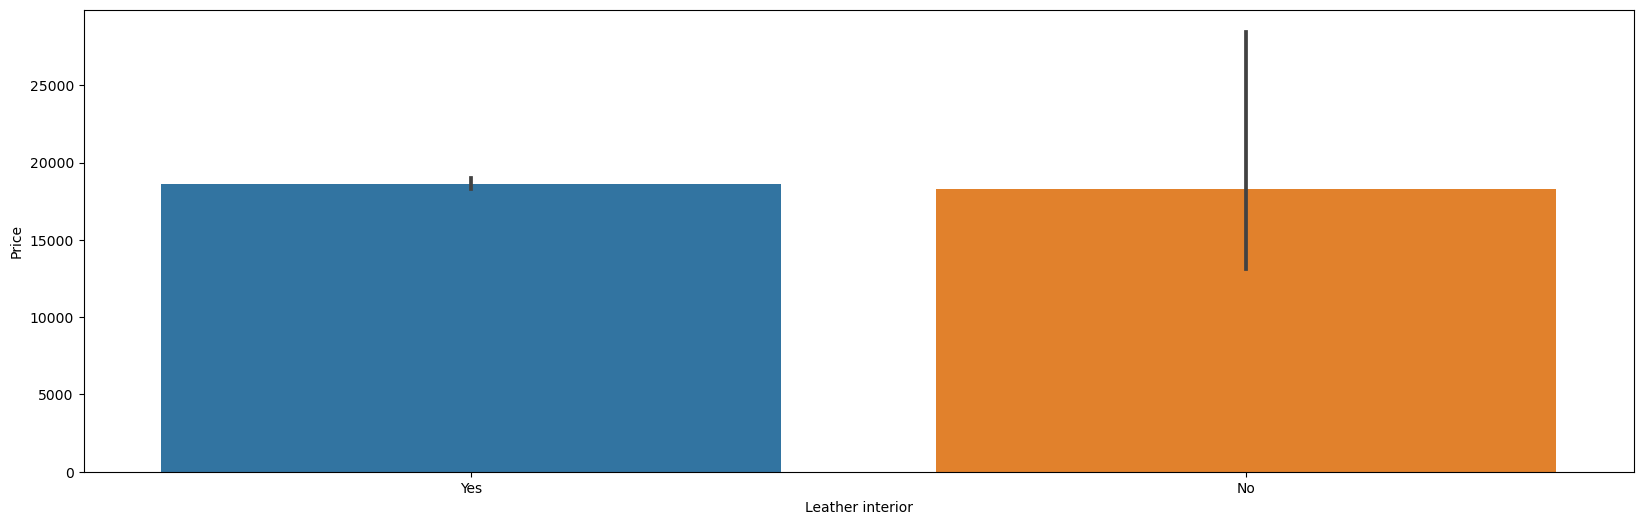

Fuel type


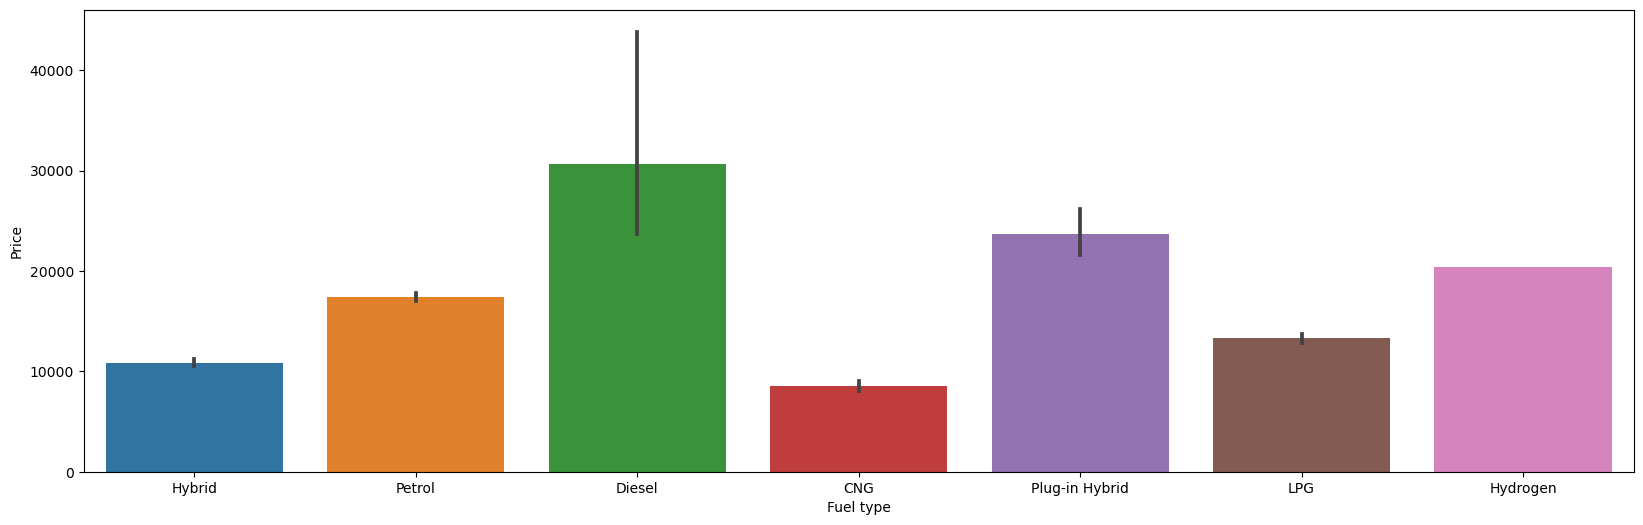

Engine volume


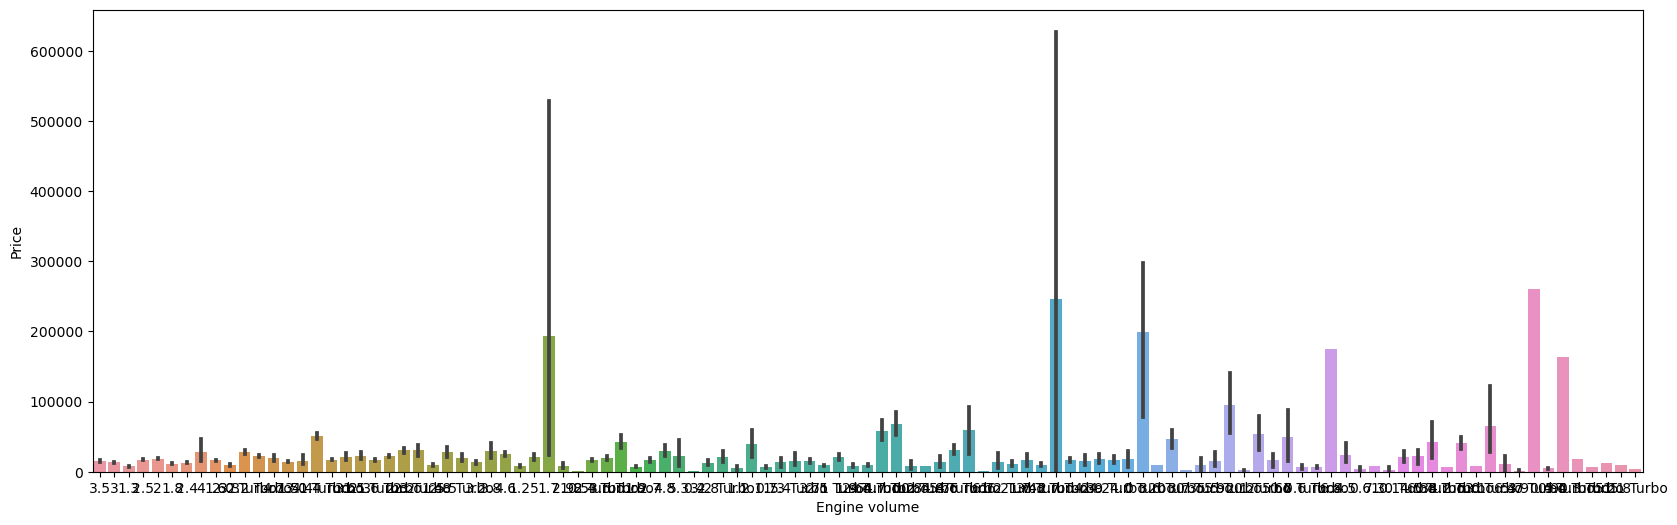

Mileage


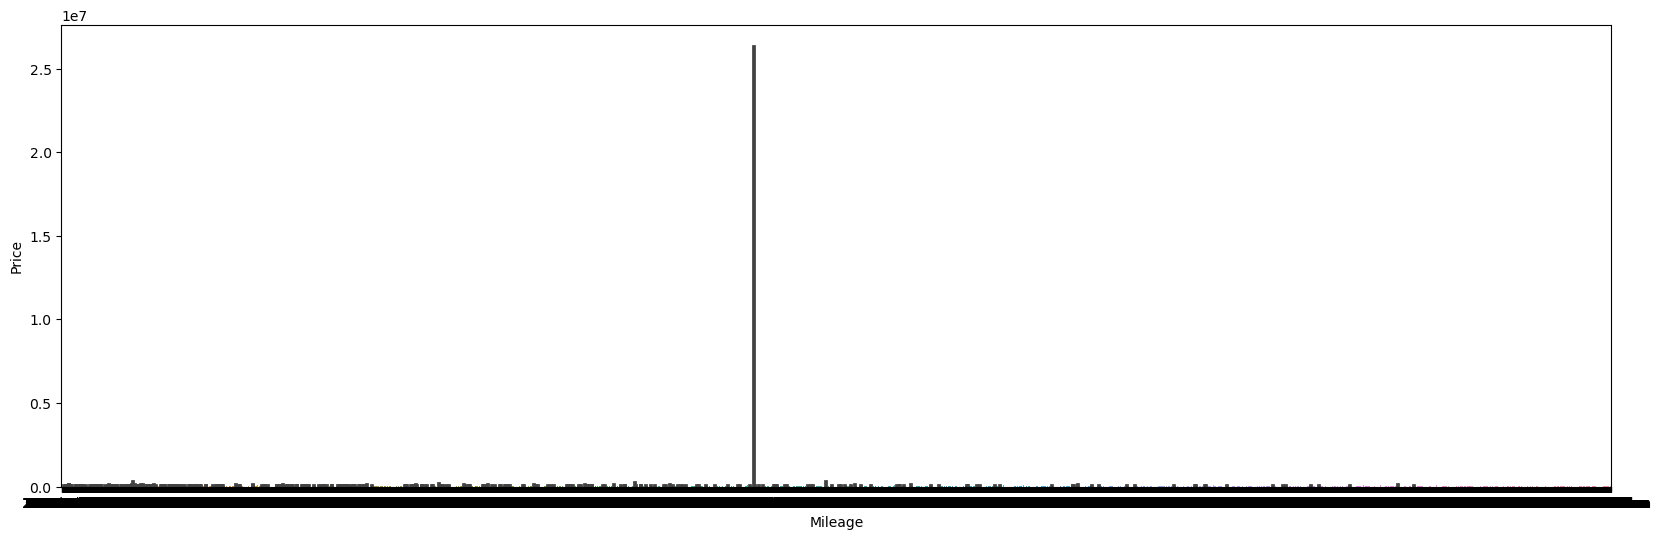

Gear box type


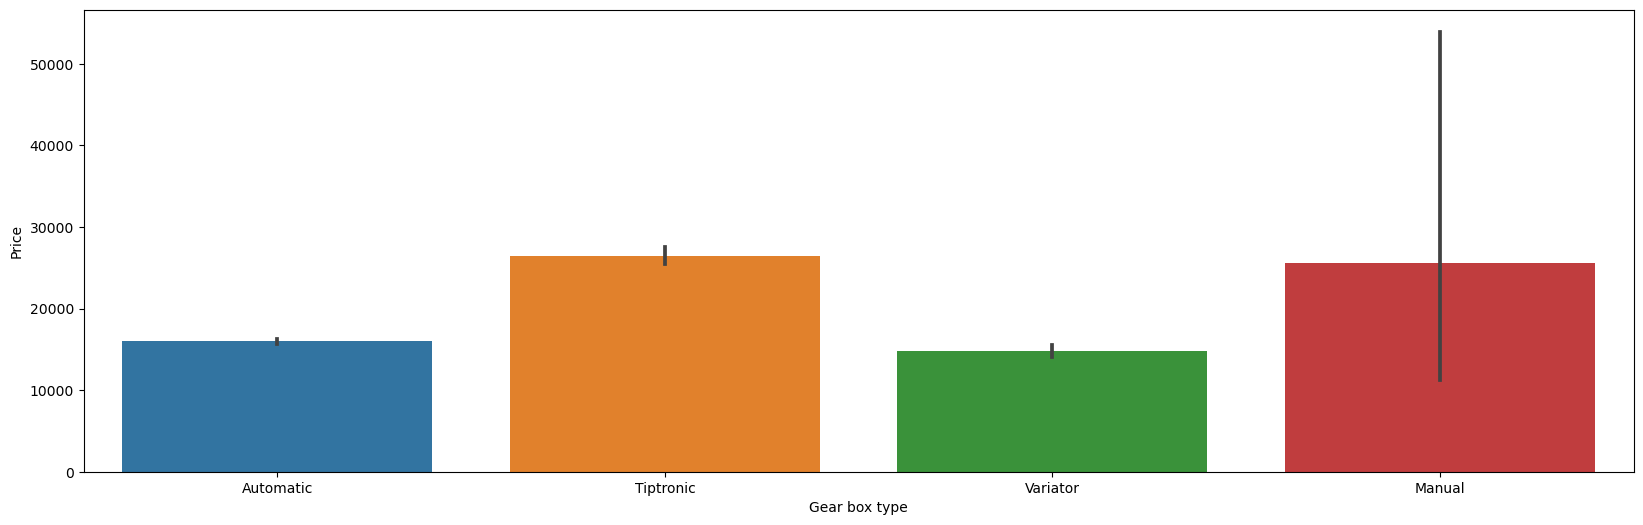

Drive wheels


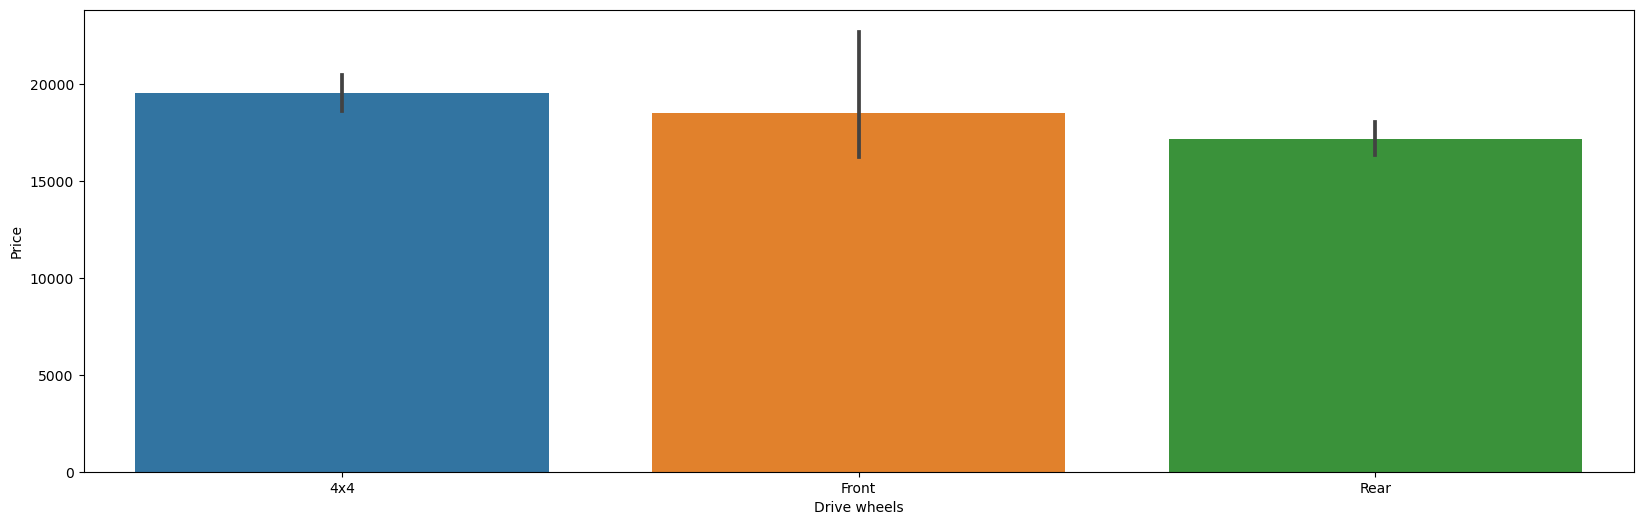

Doors


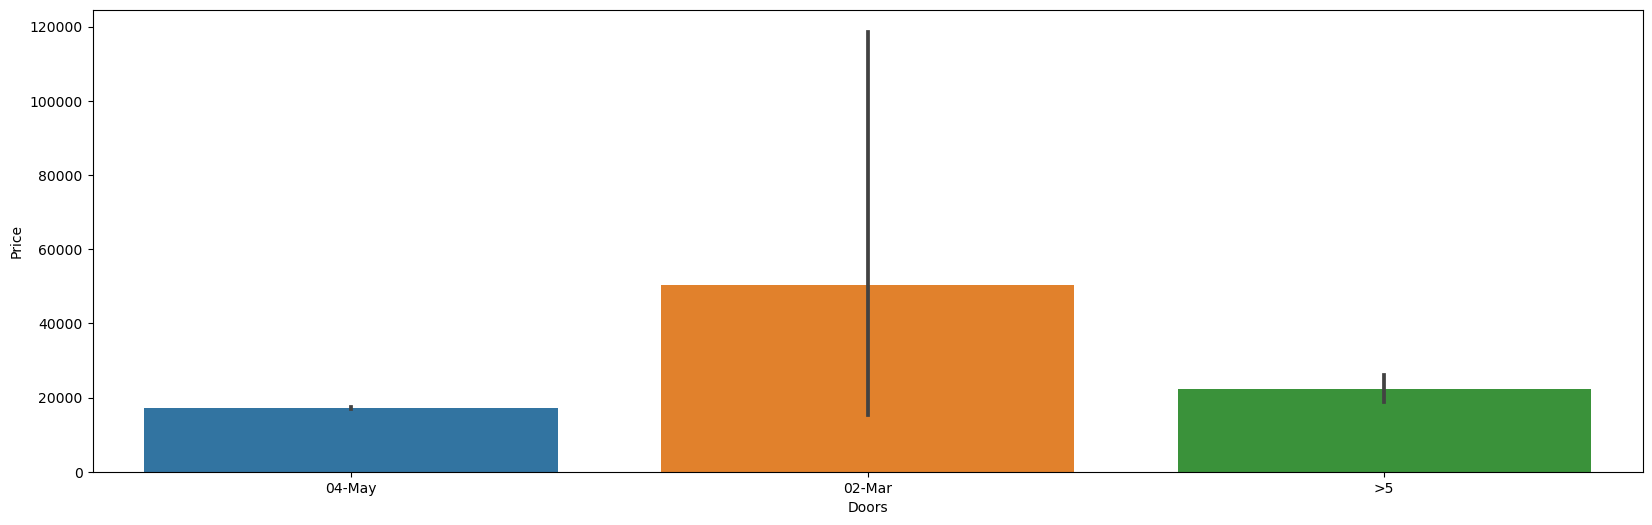

Wheel


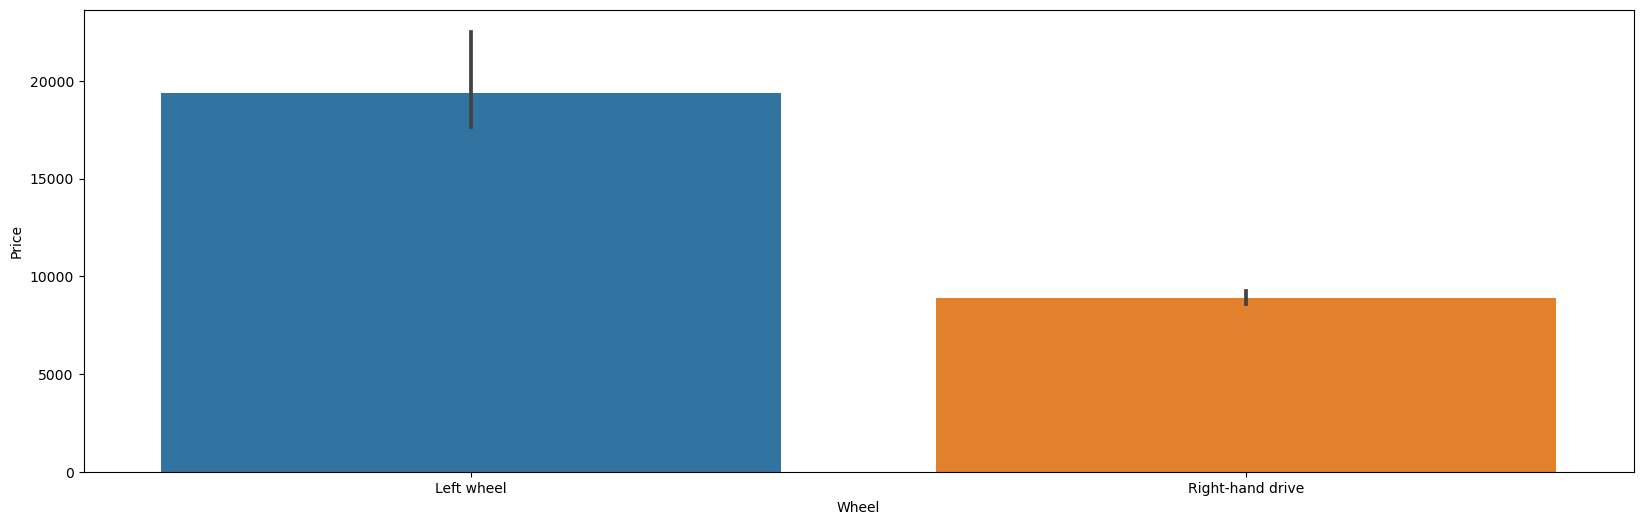

Color


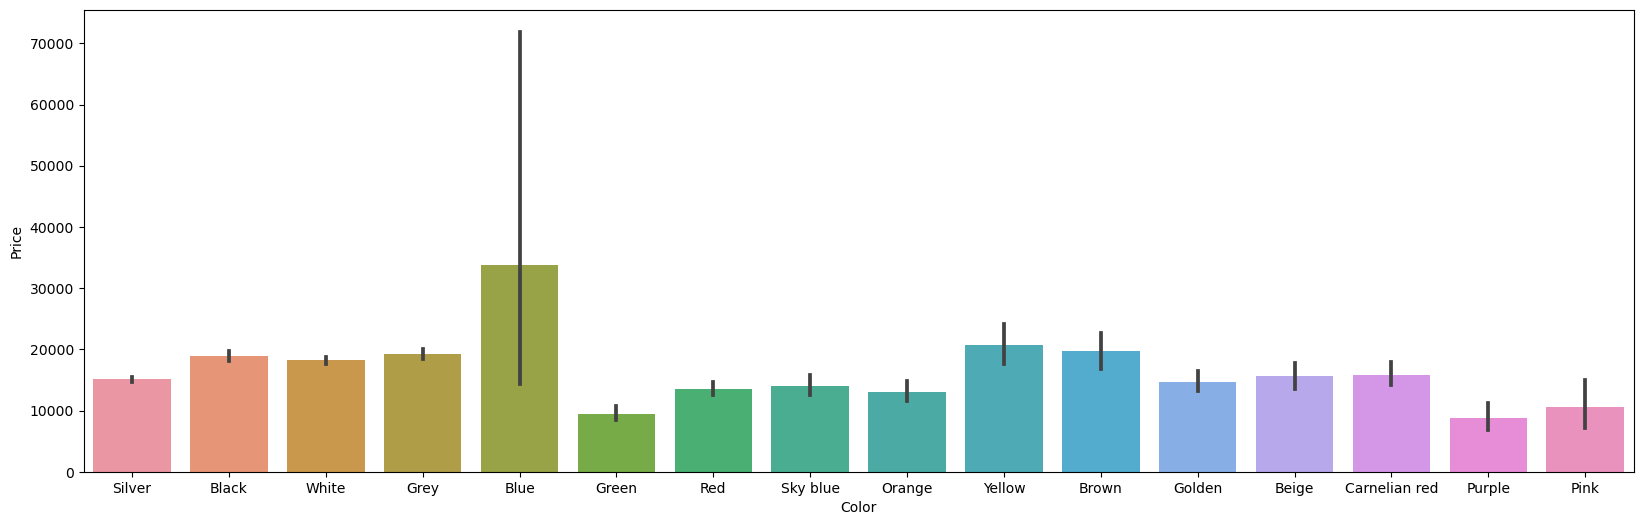

In [11]:
for i in categorical_columns:
    print(i)
    plt.figure(figsize=(20,6))
    sns.barplot(x=categorical_columns[i],y=data['Price'])
    plt.show()

In [12]:
data[data['Manufacturer'] == 'ROLLS-ROYCE']

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
10265,157,0,ROLLS-ROYCE,Phantom,1939,Cabriolet,Yes,Petrol,5,129000 km,8.0,Automatic,Rear,04-May,Left wheel,Silver,0
15613,200,0,ROLLS-ROYCE,Phantom,1939,Limousine,Yes,Petrol,2.2,169000 km,4.0,Manual,Rear,04-May,Left wheel,White,0


In [13]:
data.groupby('Manufacturer')["Price"].mean().sort_values()

Manufacturer
ROLLS-ROYCE       178.500000
ROVER            2433.333333
ZAZ              3822.500000
MOSKVICH         4609.000000
VAZ              4613.583333
                   ...      
LAND ROVER      54053.489796
FERRARI         66955.500000
OPEL            73305.617128
BENTLEY        197574.500000
LAMBORGHINI    872946.000000
Name: Price, Length: 65, dtype: float64

In [14]:
# cars can't be less than a 1000$ atleast so let's remove those
data = data[data['Price'].apply(lambda x:x>1000)]

In [15]:
# so we can see an OPEL Combo is said to be worth 26Mil$ whereas a lamborghini is worth less than that. Let's remove this outlier since this could
# completely throw off the mean

In [16]:
data[data["Price"]!=data["Price"].max()]["Price"]

0        13328
1        16621
2         8467
3         3607
4        11726
         ...  
19231     5802
19232     8467
19233    15681
19234    26108
19235     5331
Name: Price, Length: 16651, dtype: int64

----
## Cleaning

In [17]:
categorical_columns.drop(columns=["Manufacturer","Model"],inplace=True)

In [18]:
categorical_columns

,Category,Leather interior,Fuel type,Engine volume,Mileage,Gear box type,Drive wheels,Doors,Wheel,Color
0,Jeep,Yes,Hybrid,3.5,186005 km,Automatic,4x4,04-May,Left wheel,Silver
1,Jeep,No,Petrol,3,192000 km,Tiptronic,4x4,04-May,Left wheel,Black
2,Hatchback,No,Petrol,1.3,200000 km,Variator,Front,04-May,Right-hand drive,Black
3,Jeep,Yes,Hybrid,2.5,168966 km,Automatic,4x4,04-May,Left wheel,White
4,Hatchback,Yes,Petrol,1.3,91901 km,Automatic,Front,04-May,Left wheel,Silver
...,...,...,...,...,...,...,...,...,...,...
19232,Coupe,Yes,CNG,2.0 Turbo,300000 km,Manual,Rear,02-Mar,Left wheel,Silver
19233,Sedan,Yes,Petrol,2.4,161600 km,Tiptronic,Front,04-May,Left wheel,Red
19234,Jeep,Yes,Diesel,2,116365 km,Automatic,Front,04-May,Left wheel,Grey
19235,Jeep,Yes,Diesel,2,51258 km,Automatic,Front,04-May,Left wheel,Black


In [19]:
data['turbo']=categorical_columns['Engine volume'].str.contains("Turbo")
data['Engine volume']=categorical_columns["Engine volume"].apply(lambda x:x.split(" ")[0]).astype(np.float64)

In [20]:
data['Drive wheels']=data['Drive wheels'].replace("4x4","All")

In [21]:
data['Mileage']=data['Mileage'].apply(lambda x:x.split(" ")[0].strip()).astype(np.int64)

In [22]:
data['Doors']=data['Doors'].map({
    '04-May':4,
    '02-Mar':2,
    ">5":5
})

---
## Normalisation

In [23]:
data.head()

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,turbo
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,All,4,Left wheel,Silver,12,False
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,All,4,Left wheel,Black,8,False
2,8467,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,2,False
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,All,4,Left wheel,White,0,False
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,4,False


/tmp/ipykernel_20/1471309030.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Mileage'])


<Axes: xlabel='Mileage', ylabel='Density'>

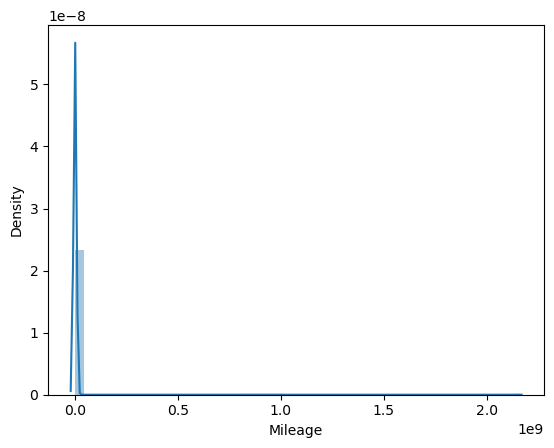

In [24]:
sns.distplot(data['Mileage'])

/tmp/ipykernel_20/747478538.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Cylinders'])


<Axes: xlabel='Cylinders', ylabel='Density'>

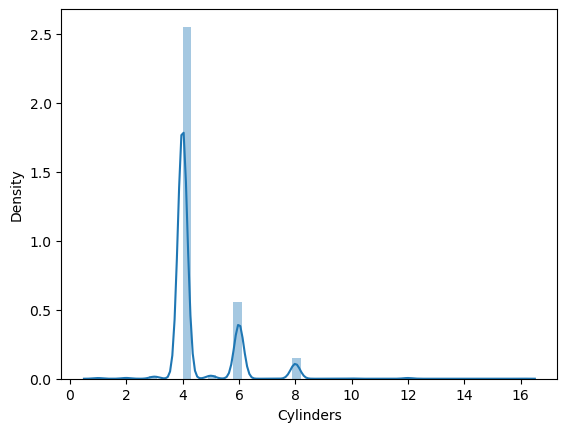

In [25]:
sns.distplot(data['Cylinders'])

0.796470619529868


/tmp/ipykernel_20/3000275776.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Cylinders'].apply(np.log))


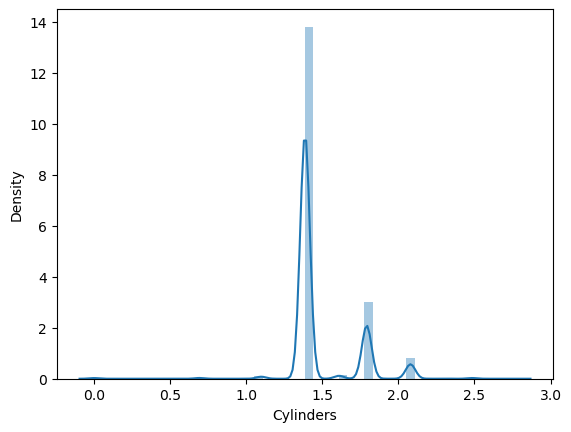

In [26]:
print(data['Cylinders'].apply(np.log).skew())
sns.distplot(data['Cylinders'].apply(np.log))
data['Normalised Cylinders']=data['Cylinders'].apply(np.log)

/tmp/ipykernel_20/1091421804.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Airbags'])


<Axes: xlabel='Airbags', ylabel='Density'>

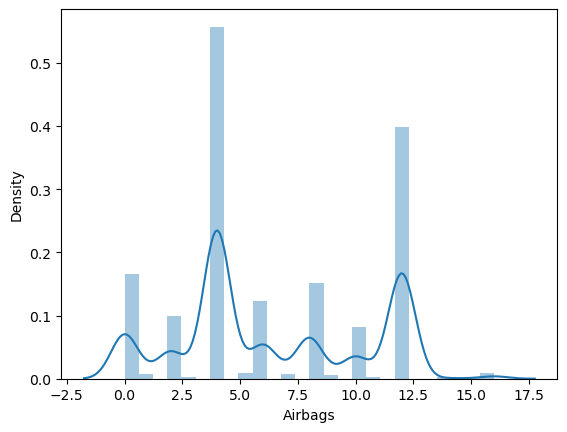

In [27]:
sns.distplot(data['Airbags'])

/tmp/ipykernel_20/1471309030.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Mileage'])


<Axes: xlabel='Mileage', ylabel='Density'>

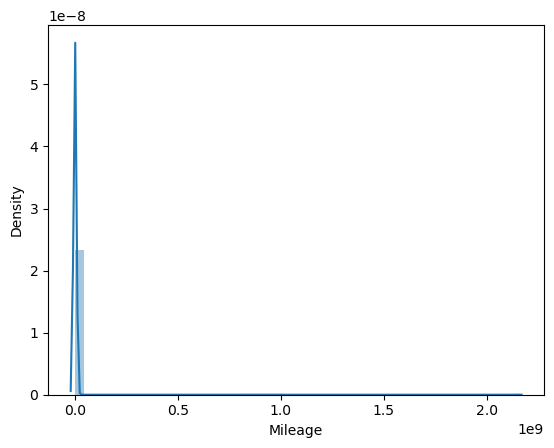

In [28]:
sns.distplot(data['Mileage'])

In [29]:
data.head()

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,turbo,Normalised Cylinders
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,All,4,Left wheel,Silver,12,False,1.791759
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,All,4,Left wheel,Black,8,False,1.791759
2,8467,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,2,False,1.386294
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,All,4,Left wheel,White,0,False,1.386294
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,4,False,1.386294


---
## Encoding

In [30]:
data['Leather interior'] = data['Leather interior'].map({
    'Yes':1,
    'No':0
})
data['Wheel'] = data['Wheel'].map({
    'Left wheel':1,
    'Right-hand drive':0
})
data['turbo'] = data['turbo'].map({
    'True':1,
    'False':0
})

In [31]:
categorical_columns,numerical_columns = get_cols(data)

In [32]:
categorical_columns=categorical_columns.drop(columns=['Manufacturer','Model'])

In [33]:
categorical_columns

,Category,Fuel type,Gear box type,Drive wheels,Color
0,Jeep,Hybrid,Automatic,All,Silver
1,Jeep,Petrol,Tiptronic,All,Black
2,Hatchback,Petrol,Variator,Front,Black
3,Jeep,Hybrid,Automatic,All,White
4,Hatchback,Petrol,Automatic,Front,Silver
...,...,...,...,...,...
19231,Sedan,Diesel,Automatic,Rear,Grey
19232,Coupe,CNG,Manual,Rear,Silver
19233,Sedan,Petrol,Tiptronic,Front,Red
19234,Jeep,Diesel,Automatic,Front,Grey


In [34]:
X=data.drop(columns=['Manufacturer','Model','Price'])
y=data.Price

In [35]:
categorical_columns

,Category,Fuel type,Gear box type,Drive wheels,Color
0,Jeep,Hybrid,Automatic,All,Silver
1,Jeep,Petrol,Tiptronic,All,Black
2,Hatchback,Petrol,Variator,Front,Black
3,Jeep,Hybrid,Automatic,All,White
4,Hatchback,Petrol,Automatic,Front,Silver
...,...,...,...,...,...
19231,Sedan,Diesel,Automatic,Rear,Grey
19232,Coupe,CNG,Manual,Rear,Silver
19233,Sedan,Petrol,Tiptronic,Front,Red
19234,Jeep,Diesel,Automatic,Front,Grey


In [36]:
encoder = ColumnTransformer(transformers=[
    ('categorical',OneHotEncoder(handle_unknown="ignore"),categorical_columns.columns)
])
pipeline = Pipeline(steps=[('encoder',encoder),('linearRegression',LinearRegression())])

In [37]:
pipeline

Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Category', 'Fuel type', 'Gear box type', 'Drive wheels', 'Color'], dtype='object'))])),
                ('linearRegression', LinearRegression())])

In [38]:
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True,train_size=0.3,random_state=1234)
pipeline.fit(X_train,y_train)
preds=pipeline.predict(X_test)
print(r2_score(y_test,preds),mean_absolute_error(y_test,preds))

0.00012935122100743435 13167.059903746973
